Objective:
To implement the CNN techniques learnt as a part of the course.

Learning Outcomes:
* Pre-processing of image data.
* Visualization of images.
* Building CNN.
* Evaluate the Model.
* The motive of the project is to make the learners capable to handle images/image classification problems, during this process you should also be capable to handle real image files, not just limited to a numpy array of image pixels.

# Import the libraries

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import seaborn as sns
from sklearn.model_selection import train_test_split

import cv2
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# set seeds
np.random.seed(1)
tf.random.set_seed(1)


Using TensorFlow backend.


# Load dataset

In [2]:
# Images
images = np.load('images.npy')
# y labels
labels = pd.read_csv('Labels.csv')

# Print shape of data

In [3]:
images.shape

(4750, 128, 128, 3)

In [4]:
labels.shape

(4750, 1)

# Visualize the images in dataset

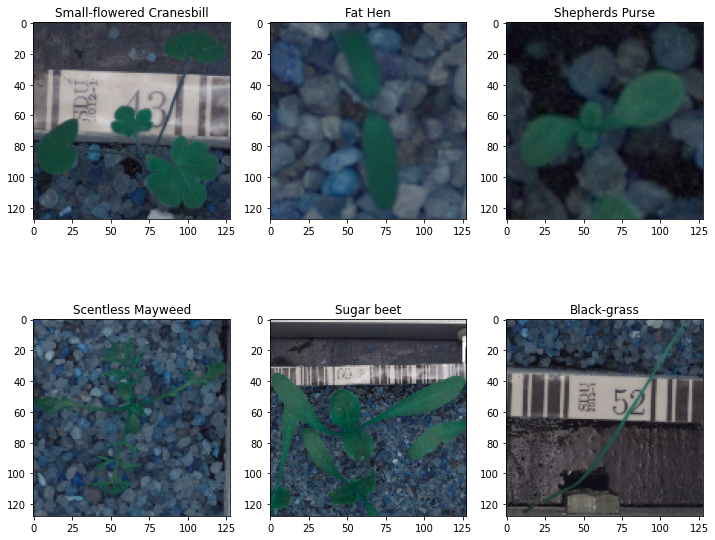

In [38]:
f, plot2by3 = plt.subplots(2,3, figsize=(12,10))

plot2by3[0,0].imshow(images[11]) 
plot2by3[0,0].title.set_text(labels.loc[11].Label)

plot2by3[0,1].imshow(images[511]) 
plot2by3[0,1].title.set_text(labels.loc[511].Label)

plot2by3[0,2].imshow(images[1011]) 
plot2by3[0,2].title.set_text(labels.loc[1011].Label)

plot2by3[1,0].imshow(images[3011]) 
plot2by3[1,0].title.set_text(labels.loc[3011].Label)

plot2by3[1,1].imshow(images[3511]) 
plot2by3[1,1].title.set_text(labels.loc[3511].Label)

plot2by3[1,2].imshow(images[4011]) 
plot2by3[1,2].title.set_text(labels.loc[4011].Label)

# Gaussian Blurring.

In [6]:
# empty numpy array, used to store the new values after applying Gaussian Blurring filter to the original image.
BlurredX = np.empty((4750, 128, 128, 3)) 

for idx, img in enumerate(images):
    BlurredX[idx] = cv2.GaussianBlur(img, (5, 5), 0)

# Normalization.

In [7]:
BlurredX = BlurredX.astype('float32')
BlurredX /= 255.0

# Visualize data after pre-processing

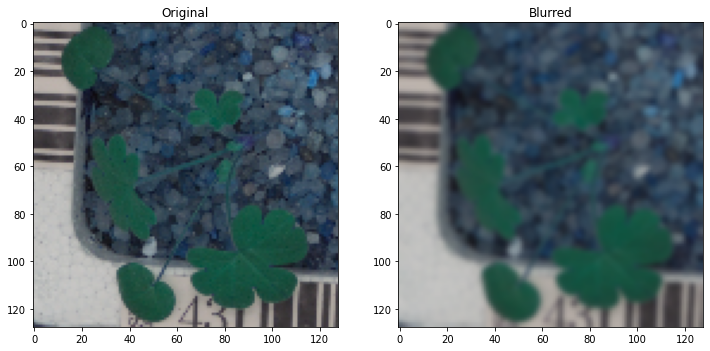

In [36]:
f, plotarray = plt.subplots(1,2, figsize=(12,10))

plotarray[0].imshow(images[101])
plotarray[0].title.set_text("Original")

plotarray[1].imshow(BlurredX[101])
plotarray[1].title.set_text("Blurred")

<AxesSubplot:xlabel='Label'>

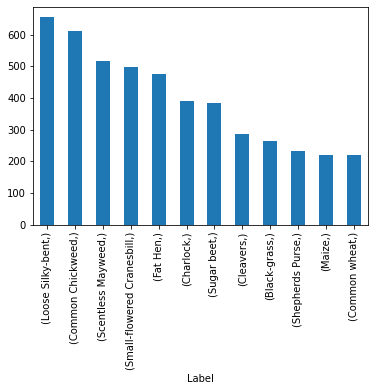

In [37]:
labels.value_counts().plot(kind='bar')

# Make data compatible

## Convert labels to one-hot-vectors

In [10]:
enc = LabelBinarizer()
BinariedY = enc.fit_transform(labels)

## Print the label for y_train[0]

In [11]:
BinariedY[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## Split the dataset into training, testing, and validation set

* training set : 70%
* testing set: 30%

In [12]:
X_train, X_test, y_train, y_test = train_test_split(BlurredX, BinariedY, test_size=0.3, random_state=22)

## Split test data into test and validation set with test_size = 0.5

In [13]:
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=22)

## Checking the shape of data

In [29]:
X_train.shape

(3325, 128, 128, 3)

In [30]:
y_train.shape

(3325, 12)

In [31]:
X_test.shape

(712, 128, 128, 3)

In [32]:
y_test.shape

(712, 12)

In [33]:
X_val.shape

(713, 128, 128, 3)

In [35]:
Y_val.shape

(713, 12)

Shape of X data 128 by 128 and 3 dimensional while y data shape is 12 distinct value which are compatible with Keras models already.

# Building CNN Model

## Define layers.

In [14]:
# CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(128, (3,3),padding = 'Same', activation ='relu', input_shape = (128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

## Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

In [15]:
model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

# Fit and evaluate model and print confusion matrix

In [16]:
model.fit(X_train, y_train, epochs = 100, validation_data = (X_val,Y_val),batch_size = 64, verbose=1)

Train on 3325 samples, validate on 713 samples
Epoch 1/100
3325/3325 [==============================] - 393s 118ms/step - loss: 2.4065 - accuracy: 0.2556 - val_loss: 6.6316 - val_accuracy: 0.0842
Epoch 2/100
3325/3325 [==============================] - 389s 117ms/step - loss: 1.5563 - accuracy: 0.4794 - val_loss: 6.7506 - val_accuracy: 0.0365
Epoch 3/100
3325/3325 [==============================] - 389s 117ms/step - loss: 1.2002 - accuracy: 0.6003 - val_loss: 9.1331 - val_accuracy: 0.0379
Epoch 4/100
3325/3325 [==============================] - 390s 117ms/step - loss: 1.0186 - accuracy: 0.6577 - val_loss: 15.8615 - val_accuracy: 0.0379
Epoch 5/100
3325/3325 [==============================] - 387s 116ms/step - loss: 0.8558 - accuracy: 0.7143 - val_loss: 13.6239 - val_accuracy: 0.0379
Epoch 6/100
3325/3325 [==============================] - 391s 118ms/step - loss: 0.6818 - accuracy: 0.7624 - val_loss: 13.2485 - val_accuracy: 0.0379
Epoch 7/100
3325/3325 [==============================] -

3325/3325 [==============================] - 401s 121ms/step - loss: 0.0602 - accuracy: 0.9823 - val_loss: 1.7765 - val_accuracy: 0.7265
Epoch 56/100
3325/3325 [==============================] - 394s 119ms/step - loss: 0.0503 - accuracy: 0.9826 - val_loss: 3.1863 - val_accuracy: 0.5764
Epoch 57/100
3325/3325 [==============================] - 391s 118ms/step - loss: 0.0576 - accuracy: 0.9841 - val_loss: 1.1089 - val_accuracy: 0.8177
Epoch 58/100
3325/3325 [==============================] - 392s 118ms/step - loss: 0.0682 - accuracy: 0.9808 - val_loss: 1.3336 - val_accuracy: 0.8261
Epoch 59/100
3325/3325 [==============================] - 395s 119ms/step - loss: 0.0708 - accuracy: 0.9783 - val_loss: 1.5646 - val_accuracy: 0.7742
Epoch 60/100
3325/3325 [==============================] - 391s 118ms/step - loss: 0.0675 - accuracy: 0.9805 - val_loss: 1.3185 - val_accuracy: 0.7924
Epoch 61/100
3325/3325 [==============================] - 391s 118ms/step - loss: 0.0589 - accuracy: 0.9847 - val

In [17]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 64)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7995364264156042
Test accuracy: 0.75


In [18]:
# Prediction
yPredict = model.predict(X_test)

In [19]:
yPredictValues = np.argmax(yPredict,axis = 1)
yTestValues = np.argmax(y_test,axis=1)

### Confusion Matrix

In [20]:
CM = confusion_matrix(yTestValues,yPredictValues)

In [21]:
CM

array([[11,  0,  0,  0,  0,  1, 37,  0,  0,  0,  0,  0],
       [ 0, 51,  5,  0,  0,  4,  0,  1,  0,  3,  0,  0],
       [ 0,  0, 29,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 74,  1,  0,  0,  0,  2,  5,  2,  2],
       [ 5,  0,  0,  0, 16,  3, 12,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 65,  3,  0,  0,  1,  0,  1],
       [ 6,  0,  0,  0,  0,  1, 89,  0,  0,  0,  1,  1],
       [ 0,  0,  0,  3,  0,  0,  0, 22,  2,  0,  1,  1],
       [ 0,  0,  1,  3,  2,  0,  5,  2, 54,  7,  0,  4],
       [ 0,  0,  3,  3,  0,  1,  0,  0,  7, 17,  0,  1],
       [ 0,  0,  4,  0,  0,  9,  0,  2,  0,  5, 58,  0],
       [ 1,  0,  0,  1,  2,  3,  0,  0,  2,  0,  3, 48]], dtype=int64)

<AxesSubplot:>

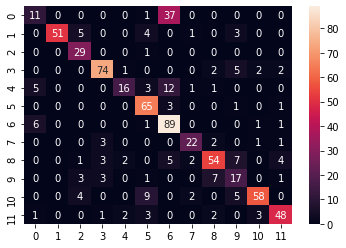

In [22]:
#plt.figure(figsize)
sns.heatmap(CM,annot=True)

In [23]:
SortedLabels = set(labels["Label"])
SortedLabels = list(SortedLabels)
SortedLabels.sort()

# Prediction Visualization

Text(0.5, 1.0, 'Actual = Scentless Mayweed and Predicted = Scentless Mayweed')

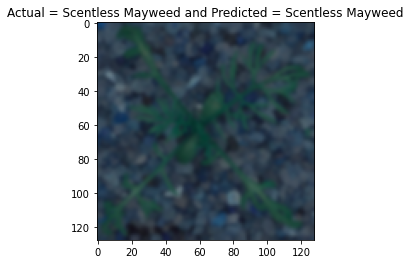

In [24]:
# Visualize predictions for

#1) X_test[2]

plt.imshow(X_test[2],cmap='gray')
predictedLabel = SortedLabels[yPredictValues[2]]
actualLabel = SortedLabels[yTestValues[2]]
title = "Actual = {} and Predicted = {}".format(actualLabel,predictedLabel)
plt.title(title)

Text(0.5, 1.0, 'Actual = Sugar beet and Predicted = Sugar beet')

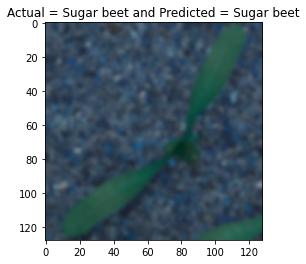

In [25]:
#2) X_test[3]

plt.imshow(X_test[3],cmap='gray')
predictedLabel = SortedLabels[yPredictValues[3]]
actualLabel = SortedLabels[yTestValues[3]]
title = "Actual = {} and Predicted = {}".format(actualLabel,predictedLabel)
plt.title(title)



Text(0.5, 1.0, 'Actual = Fat Hen and Predicted = Fat Hen')

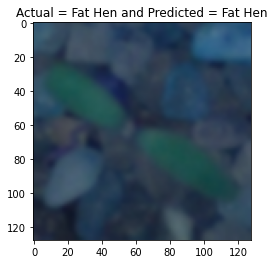

In [26]:
#3) X_test[33]

plt.imshow(X_test[33],cmap='gray')
predictedLabel = SortedLabels[yPredictValues[33]]
actualLabel = SortedLabels[yTestValues[33]]
title = "Actual = {} and Predicted = {}".format(actualLabel,predictedLabel)
plt.title(title)



Text(0.5, 1.0, 'Actual = Small-flowered Cranesbill and Predicted = Small-flowered Cranesbill')

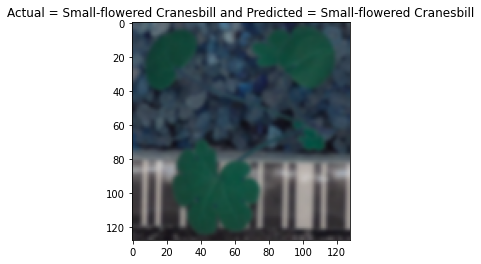

In [27]:
#4) X_test[36]

plt.imshow(X_test[36],cmap='gray')
predictedLabel = SortedLabels[yPredictValues[36]]
actualLabel = SortedLabels[yTestValues[36]]
title = "Actual = {} and Predicted = {}".format(actualLabel,predictedLabel)
plt.title(title)



Text(0.5, 1.0, 'Actual = Cleavers and Predicted = Cleavers')

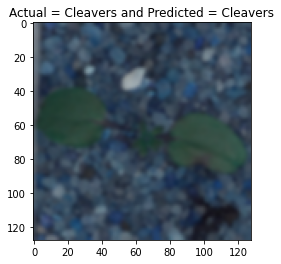

In [28]:
#5) X_test[59]

plt.imshow(X_test[59],cmap='gray')
predictedLabel = SortedLabels[yPredictValues[59]]
actualLabel = SortedLabels[yTestValues[59]]
title = "Actual = {} and Predicted = {}".format(actualLabel,predictedLabel)
plt.title(title)